## EPI phase correction
###### Author: Zimu Huo
###### Date: 05.2022

Due to the alternating direction of the EPI readout lines, hardware imperfections such as timing delays, eddy currents, and gradient coil heating can cause misalignment of the forward and reverse lines in k-space. This misalignment manifests itself in the images as a Nyquist (N/2) ghost in the phase encode direction and sinusoidal modulation of the object in the frequency encode direction.

The sampling incoherence is removed when interleving the positive and negative echos. However, a 2x acceleration is introduced to each dataset, resulting noise amplification 

-------------------------------------------------------------------------
References

    [1] 
    Author:  Xie V, Lyu M, Liu Y, Feng Y, Wu E
    Title: Robust EPI Nyquist ghost removal by incorporating phase error correction with sensitivity encoding (PEC-SENSE)
    Link: https://pubmed.ncbi.nlm.nih.gov/28590562/


In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../../')
import numpy as np
import matplotlib.pyplot as plt
from util.fft import * 
from util.phantom import * 
from util.coil import * 
from util.tool import * 
from util.cgSolver import * 

In [2]:
import scipy.io
def get_tissue_images(): # helper function to create realistic brain phantom
    tissuetype = ['graymatter', 'deep_graymatter', 'whitematter', 'csf']
    T2 = [110, 100, 60, 1500]
    T2s = [40, 45, 50, 1000]
    mat = scipy.io.loadmat('../lib/tissue_images.mat')
    tissues = mat.get("tissue_images")[:,:,:,:]
    return np.squeeze(tissues), tissuetype

In [3]:
tissues,tissuetype = get_tissue_images()
ny, nx, nz, nt = tissues.shape
nc = 4 # number of coils 

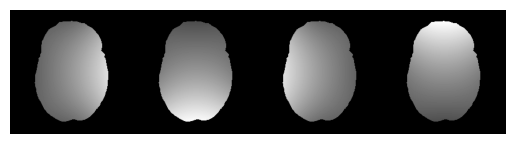

In [4]:
TE = 100
ideal_image = np.zeros([ny, nx, nz], dtype = complex)
for t in range(nt):
    ideal_image += tissues[...,t] * np.exp(TE/t2(tissuetype[t]))
images = ideal_image[:,:,nz//2] # we are only interested in one slice 
data = fft2c(images)

coils = generate_birdcage_sensitivities(matrix_size = ny, number_of_coils = nc)
images = np.repeat(images[...,np.newaxis],  nc, axis = -1) * coils
data = fft2c(images)
coilmaps = cmap(images) 
show(coilmaps)

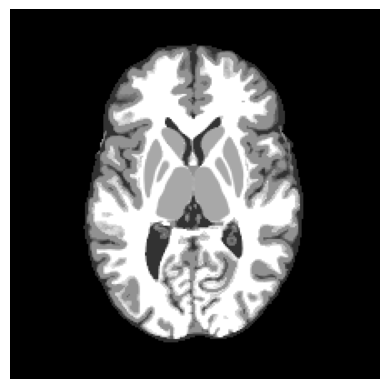

In [5]:
# plot the simulated ground truth image 
show(rsos(images))

In [6]:
# helper functions 
def apply_epi_phase(data, tvecm):
    recon = np.zeros(data.shape, dtype = complex)
    tvec = np.ones(data.shape, dtype = complex)
    tvec[1::2,...] = np.tile(tvecm.reshape(-1,1), data.shape[2])
    data = ifft(data,1)
    recon = data * tvec
    recon = ifft(recon,0)
    return fft2c(recon) 

<div style="font-size: 1.2em;">
Hardware imperfections can cause a slight deviation between otherwise equivalent points along the frequency encoding axis between even and odd echoes in the EPI readout. Such misalignment of the echoes in K-space leads to an artifact known as Nyquist ghosting. This artifact manifests as a superposition of the true image and a copy shifted by half of the field of view (FOV) in the phase encoding direction. Additionally, a cosine modulation of the signal intensities occurs in the frequency encoding direction.

The misalignment between the forward and reverse kx lines is typically modeled as a linear phase difference in the hybrid space (after Fourier transforming the data along the frequency encoding axis) as follows:

<div style="font-size: 1.2em;">
\[ S(x,k_{y_{odd}}) = e^{i \left(\frac{\pi \alpha}{N_x}x + \beta\right)} \]
</div>

where:

- \( x \) is the index of the position in the readout direction of total size \( N_x \),
- \( a \) is the slope of the phase due to the constant time echo delay,
- \( b \) is a constant off-resonance phase shift between the even and odd readouts in K-space.
</div>


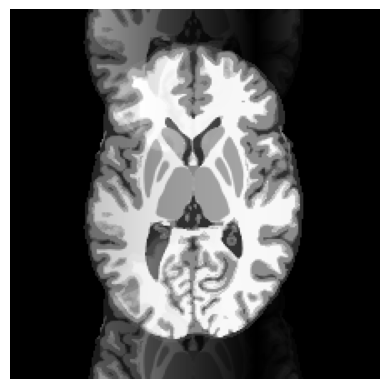

In [7]:
a = 3.00
b = -0.5

x = np.linspace(-0.5, 0.5, nx)
tvecm = np.exp(1j* (a*x+b)) 
data = apply_epi_phase(data, tvecm)
plt.figure()
plt.imshow(rsos(ifft2c(data)), cmap = "gray")
plt.axis('off')
plt.show()

In [1]:
import cv2 as cv2
def epi_phasecorrection_pecsense(data, coilmaps):
    # perform 2 separate sense recon to correct epi ghost
    # Author: Zimu Huo 
    even = np.zeros(data.shape, dtype = complex)
    odd = np.zeros(data.shape, dtype = complex)
    even[::2] = data[::2]
    odd[1::2] = data[1::2]
    even_recon = cg_sense(even, coilmaps) 
    odd_recon = cg_sense(odd, coilmaps)
    dif = np.angle(even_recon * odd_recon.conj())
    dif = np.float32(dif)
    dif = cv2.bilateralFilter(dif,15,80,80)
    even_coilmaps = np.copy(coilmaps)
    odd_coilmaps = coilmaps *np.repeat(( np.exp(-1j*dif))[:, :, None], repeats=nc, axis=-1)
    recon = cg_sense(np.concatenate((even, odd), axis=-1), np.concatenate((even_coilmaps, odd_coilmaps), axis=-1), 2) 
    return recon

In [9]:
recon = epi_phasecorrection_pecsense(data, coilmaps)

<div style="font-size: 1.2em;">
here we plot the reconstruction results 
</div>

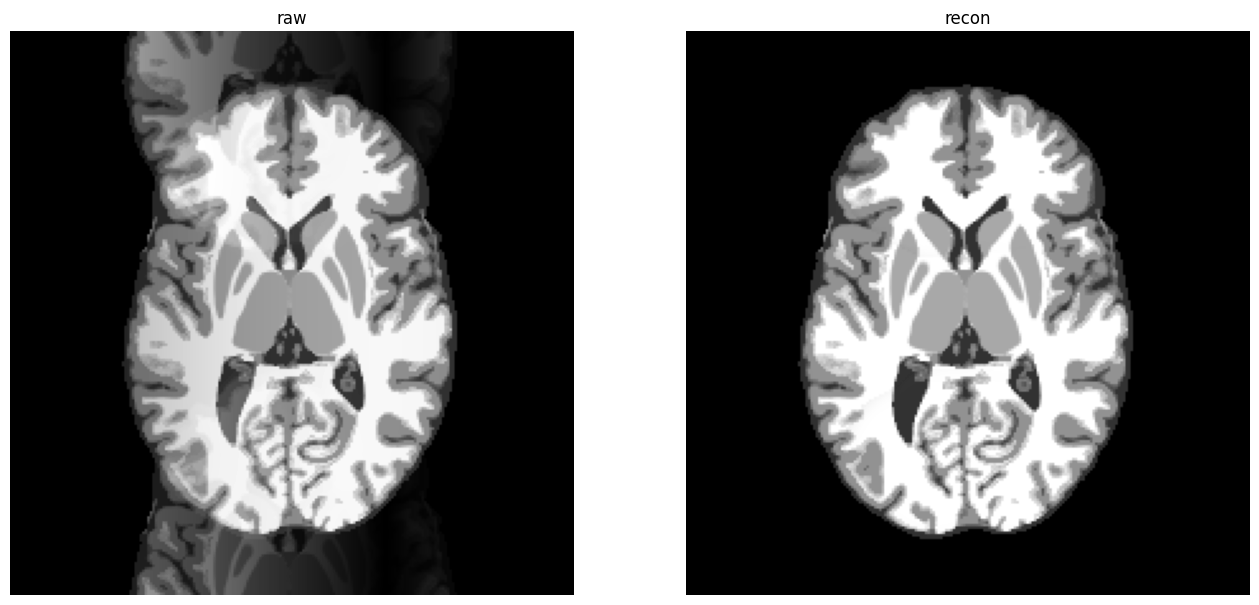

In [10]:
plt.figure(figsize =(16,12))
plt.subplot(121)
plt.title("raw")
plt.axis('off')
plt.imshow((np.abs(rsos(ifft2c(data)))), cmap ="gray")
plt.subplot(122)
plt.axis('off')
plt.title("recon")
plt.imshow((np.abs(((recon)))), cmap ="gray")
plt.show()

<div style="font-size: 1.2em;">
Lets add some noise and see what happens
</div>

In [12]:
def gaussian_noise(shape, L = None, mu = 0, sigma = 1):
    # generate noise, L is the correlation matrix (noise colors), can also be used to pre-whitten the noise
    [ny, nx, nc] = shape
    n = np.zeros([ny * nx, nc], dtype = complex)
    n.real = np.random.normal(mu, sigma, ny*nx*nc).reshape(ny * nx, nc)
    n.imag = np.random.normal(mu, sigma, ny*nx*nc).reshape(ny * nx, nc)
    if L is not None: 
        n = n@L
    return n.reshape(ny, nx, nc)

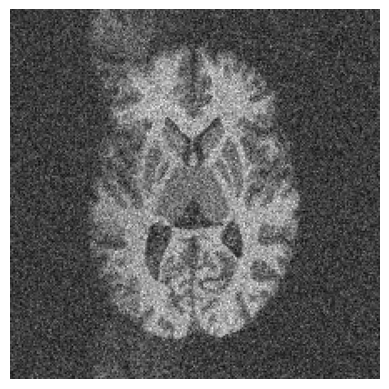

In [13]:
a = 3.00
b = -0.5

data = fft2c(images)
data = data + gaussian_noise(data.shape, sigma = 0.004)
x = np.linspace(-0.5, 0.5, nx)
tvecm = np.exp(1j* (a*x+b)) 
data = apply_epi_phase(data, tvecm)
plt.figure()
plt.imshow(rsos(ifft2c(data)), cmap = "gray")
plt.axis('off')
plt.show()

In [14]:
recon = epi_phasecorrection_pecsense(data, coilmaps)

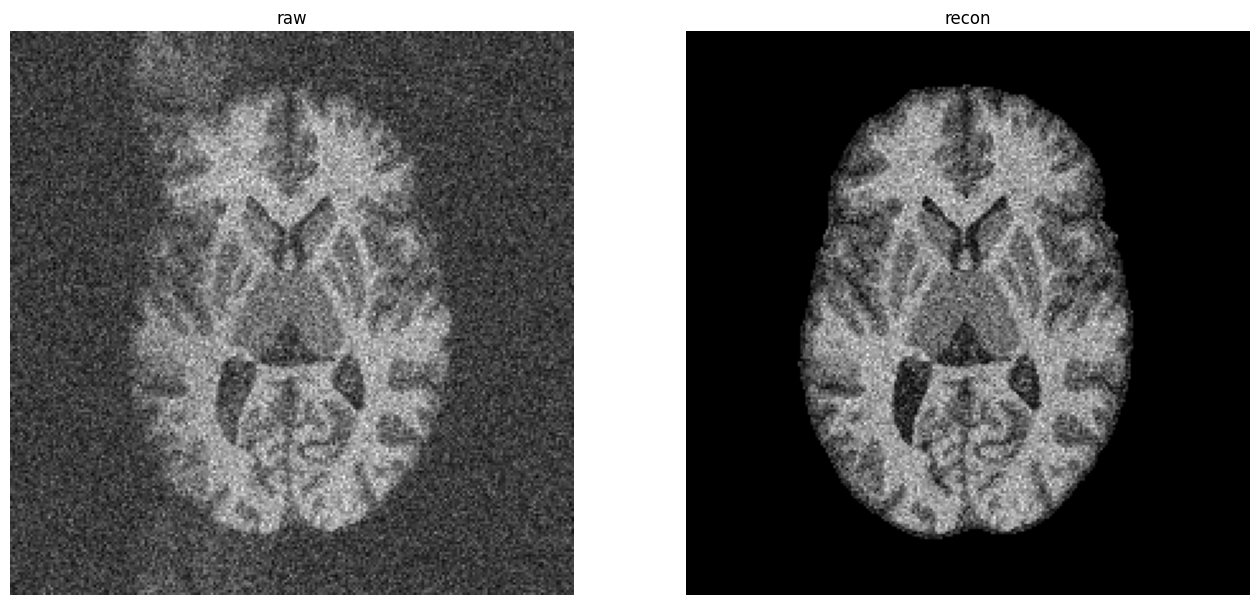

In [16]:
plt.figure(figsize =(16,12))
plt.subplot(121)
plt.title("raw")
plt.axis('off')
plt.imshow((np.abs(rsos(ifft2c(data)))), cmap ="gray")
plt.subplot(122)
plt.axis('off')
plt.title("recon")
plt.imshow((np.abs(((recon)))), cmap ="gray")
plt.show()